# CBU5201 mini-project submission

The mini-project has two separate components:


1.   **Basic component** [6 marks]: Using the genki4k dataset, build a machine learning pipeline that takes as an input an image and predicts 1) whether the person in the image is similing or not 2) estimate the 3D head pose labels in the image.
2.   **Advanced component** [10 marks]: Formulate your own machine learning problem and build a machine learning solution using the genki4k dataset (https://inc.ucsd.edu/mplab/398/). 

Your submission will consist of two Jupyter notebooks, one for the basic component and another one for advanced component. Please **name each notebook**:

* CBU5201_miniproject_basic.ipynb
* CBU5201_miniproject_advanced.ipynb

then **zip and submit them toghether**.

Each uploaded notebook should include: 

*   **Text cells**, describing concisely each step and results.
*   **Code cells**, implementing each step.
*   **Output cells**, i.e. the output from each code cell.

and **should have the structure** indicated below. Notebooks might not be run, please make sure that the output cells are saved.

How will we evaluate your submission?

*   Conciseness in your writing (10%).
*   Correctness in your methodology (30%).
*   Correctness in your analysis and conclusions (30%).
*   Completeness (10%).
*   Originality (10%).
*   Efforts to try something new (10%).

Suggestion: Why don't you use **GitHub** to manage your project? GitHub can be used as a presentation card that showcases what you have done and gives evidence of your data science skills, knowledge and experience. 

Each notebook should be structured into the following 9 sections:


# 1 Author

**Student Name**:  
**Student ID**:  



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Machine Learning pipeline

Describe your ML pipeline. Clearly identify its input and output, any intermediate stages (for instance, transformation -> models), and intermediate data moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. 

# 4 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

# 5 Modelling

Describe the ML model(s) that you will build. Explain why you have chosen them.

# 6 Methodology

Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)

# 7 Dataset

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

# 8 Results

Carry out your experiments here, explain your results.

# 9 Conclusions

Your conclusions, improvements, etc should go here

# 10 训练过程

In [14]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


1. 定义自定义数据集类

In [35]:
class Genki4kDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'C:/Users/LENOVO/Desktop/MiniProject/MiniProject/genki4k/files' 
dataset = Genki4kDataset(data_dir, transform=data_transforms)


加载预训练模型并提取特征

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的 ResNet 模型
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for inputs in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
features = np.array(features)

2. 应用 K-means 聚类


In [44]:
# 选择聚类的数量
n_clusters = 3 # 您可以根据需要调整聚类的数量

# 使用显式的 n_init 参数值, 执行K-means聚类
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(features)


3. 分析聚类结果

Silhouette Score: 0.07797137647867203


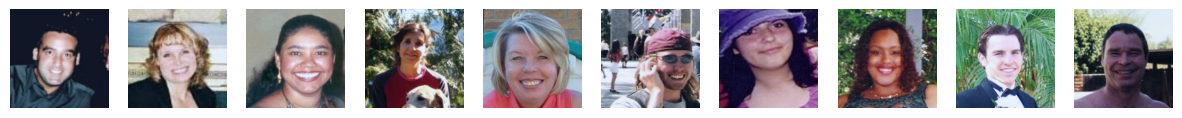

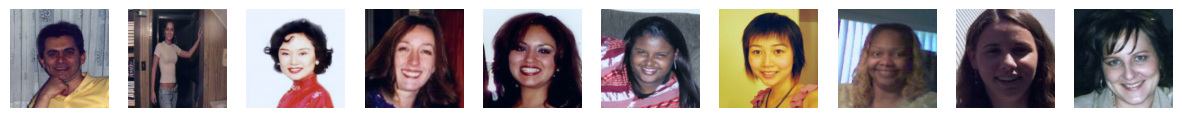

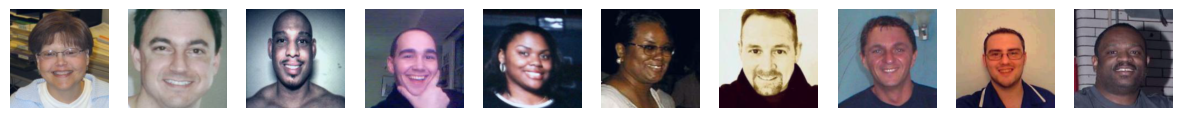

In [45]:
labels = kmeans.labels_
silhouette_avg = silhouette_score(features, labels)
print(f'Silhouette Score: {silhouette_avg}')

for i in range(n_clusters):
    cluster_indices = [j for j, label in enumerate(labels) if label == i]
    plt.figure(figsize=(15, 3))
    for j, image_index in enumerate(cluster_indices[:10]):
        plt.subplot(1, 10, j + 1)
        image = dataset[image_index]  # 这里假设 dataset 返回的是Tensor
        image = image.numpy().transpose((1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min())  # 归一化
        plt.imshow(image)
        plt.axis('off')
    plt.show()
